### Random Forest for mRNA vs non-mRNA

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

In [48]:
# Paths and parameters
TRAIN_PATH = "features_df.csv"
TEST_PATH  = "features_test.csv"
OUTPUT_CSV = "rf_predictions.csv"

RANDOM_STATE = 42
VALIDATION_SIZE = 0.20
ZERO_VARIANCE_THRESHOLD = 0.0

N_TREES = 400
MAX_DEPTH = 20
MAX_SAMPLES_PER_TREE = 0.60
MAX_FEATURES_PER_SPLIT = "sqrt"
CLASS_WEIGHT_MODE = "balanced_subsample"

In [49]:
# 1) Helper functions
## Finds threshold (0–1) that gives best Matthews Corr. Coefficient (MCC).
def pick_threshold_by_mcc(y_true, y_prob):
    thresholds = np.linspace(0, 1, 1001)
    best_thr, best_mcc = 0.5, -1.0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc = mcc
            best_thr = t
    return best_thr, best_mcc

## Align df_new to match training column order exactly.
## Missing columns are added as 0. Extra columns are dropped.
def align_to_train_columns(df_new, train_cols_in_order):
    return df_new.reindex(columns=train_cols_in_order, fill_value=0.0)

In [50]:
# 2) Load and prepare data
train_df = pd.read_csv(TRAIN_PATH)

non_feature_cols = [c for c in ["name"] if c in train_df.columns]
X_raw = train_df.drop(columns=["class"] + non_feature_cols, errors="ignore")

y_all = train_df["class"].astype(int).to_numpy()
train_original_cols = list(X_raw.columns)

In [51]:
# 3) Remove zero-variance features
selector = VarianceThreshold(threshold=ZERO_VARIANCE_THRESHOLD)
X_all = pd.DataFrame(
    selector.fit_transform(X_raw),
    columns=[col for col, keep in zip(train_original_cols, selector.get_support()) if keep]
)
selected_feature_names = list(X_all.columns)

# Ensure numeric types and no NaNs
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0)

In [52]:
# 4) Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=VALIDATION_SIZE,
    stratify=y_all,
    random_state=RANDOM_STATE
)

In [53]:
# 5) Train first RF for threshold tuning
rf_val = RandomForestClassifier(
    n_estimators=N_TREES,
    max_depth=MAX_DEPTH,
    max_features=MAX_FEATURES_PER_SPLIT,
    bootstrap=True,
    max_samples=MAX_SAMPLES_PER_TREE,
    class_weight=CLASS_WEIGHT_MODE,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_val.fit(X_train, y_train)

val_prob = rf_val.predict_proba(X_val)[:, 1]
best_thr, best_mcc = pick_threshold_by_mcc(y_val, val_prob)

In [54]:
# 6) Retrain on all training data
rf_full = RandomForestClassifier(
    n_estimators=N_TREES,
    max_depth=MAX_DEPTH,
    max_features=MAX_FEATURES_PER_SPLIT,
    bootstrap=True,
    max_samples=MAX_SAMPLES_PER_TREE,
    class_weight=CLASS_WEIGHT_MODE,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_full.fit(X_all, y_all)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_samples=0.6, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [55]:
# 7) Prepare test data
test_df = pd.read_csv(TEST_PATH)
id_col = "name" if "name" in test_df.columns else None

X_test_raw = test_df.drop(columns=[c for c in ["name", "class"] if c in test_df.columns], errors="ignore")

# Align directly to the selected features
X_test_selected = align_to_train_columns(X_test_raw, selected_feature_names)
X_test_selected = X_test_selected.apply(pd.to_numeric, errors="coerce").fillna(0.0)
# Same columns/order as training-selected features
assert list(X_all.columns) == list(selected_feature_names)
assert list(X_test_selected.columns) == list(selected_feature_names)

In [56]:
# 8) Predict test set
test_prob = rf_full.predict_proba(X_test_selected)[:, 1]
test_pred = (test_prob >= best_thr).astype(int)

In [57]:
# 9) Save predictions
id_values = test_df[id_col] if id_col else np.arange(len(test_df))
id_header = id_col if id_col else "row_id"

out = pd.DataFrame({
    id_header: id_values,
    "pred": test_pred,
    "prob": test_prob,
    "used_threshold": best_thr
})
out.to_csv(OUTPUT_CSV, index=False)
print("\nPredictions exported as:", OUTPUT_CSV)


Predictions exported as: rf_predictions.csv


In [58]:
val_pred = (val_prob >= best_thr).astype(int)
mcc_val = matthews_corrcoef(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

acc  = (tp + tn) / max(1, (tp + tn + fp + fn))   # accuracy
sens = tp / max(1, (tp + fn))                    # sensitivity
spec = tn / max(1, (tn + fp))                    # specificity
prec = tp / max(1, (tp + fp))                    # precision
rocA = roc_auc_score(y_val, val_prob)

print("\n==== Validation Results ====")
print(f"Best threshold: {best_thr:.2f}")
print(
    f"ACC={acc:.5f}  SEN={sens:.5f}  SPEC={spec:.5f}  "
    f"PREC={prec:.5f}  MCC={best_mcc:.5f} (chk {mcc_val:.5f})  ROC-AUC={rocA:.5f}"
)
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)

print("\nValidation probability range:",
      float(val_prob.min()), "→", float(val_prob.max()),
      "| median =", float(np.median(val_prob)))
print("Unique predictions (label: count):",
      dict(zip(*np.unique(val_pred, return_counts=True))))



==== Validation Results ====
Best threshold: 0.31
ACC=0.98321  SEN=0.99704  SPEC=0.97561  PREC=0.95735  MCC=0.96413 (chk 0.96413)  ROC-AUC=0.99903
Confusion matrix [[TN FP],[FN TP]]:
 [[1800   45]
 [   3 1010]]

Validation probability range: 0.0 → 1.0 | median = 0.015
Unique predictions (label: count): {np.int64(0): np.int64(1803), np.int64(1): np.int64(1055)}


In [59]:
# 11) Prediction Summary

# --- Probability Distribution ---
print(f"Probability range: {test_prob.min():.4f} → {test_prob.max():.4f}")
print(f"Median probability: {np.median(test_prob):.4f}")
print(f"Mean probability:   {np.mean(test_prob):.4f}")
print(f"Std deviation:      {np.std(test_prob):.4f}")

# --- Prediction ---
unique_labels, counts = np.unique(test_pred, return_counts=True)
total = counts.sum()
for label, count in zip(unique_labels, counts):
    percent = 100 * count / total
    label_name = "mRNA (1)" if label == 1 else "non-mRNA (0)"
    print(f"{label_name:<12}: {count:6d} ({percent:5.2f}%)")

# --- Threshold ---
print(f"\nDecision threshold used: {best_thr:.4f}")
print(f"Total predictions: {len(test_pred)}")


Probability range: 0.0000 → 1.0000
Median probability: 0.5275
Mean probability:   0.5008
Std deviation:      0.4678
non-mRNA (0):   2199 (49.80%)
mRNA (1)    :   2217 (50.20%)

Decision threshold used: 0.3130
Total predictions: 4416


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

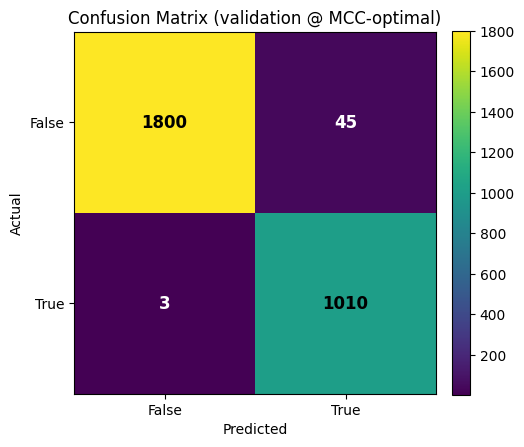

In [61]:
# --- Confusion matrix heatmap ---
fig = plt.figure(figsize=(5.2, 4.6))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest", cmap="viridis")
ax.set_title("Confusion Matrix (validation @ MCC-optimal)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["False", "True"])
ax.set_yticklabels(["False", "True"])
norm = plt.Normalize(vmin=im.get_array().min(), vmax=im.get_array().max())
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        color = "white" if norm(val) < 0.5 else "black"
        ax.text(j, i, f"{val}", va="center", ha="center",
                fontsize=12, fontweight="bold", color=color)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
fig.tight_layout()
plt.show()

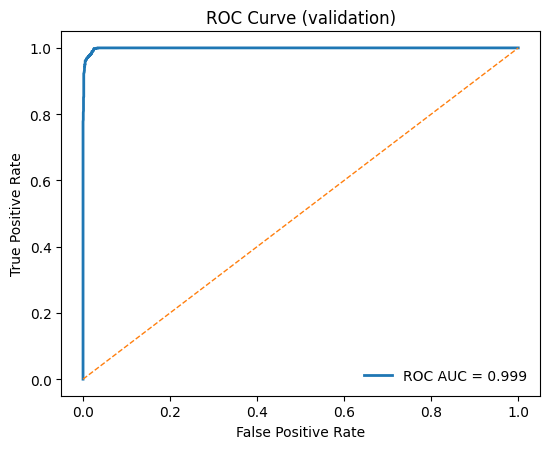

In [62]:
# === ROC curve ===
fpr, tpr, _ = roc_curve(y_val, val_prob)
rocA = auc(fpr, tpr)
plt.figure(figsize=(5.6, 4.6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC AUC = {rocA:.3f}")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.title("ROC Curve (validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

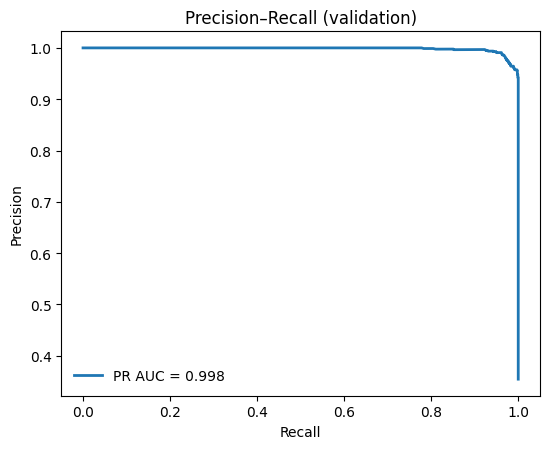

In [63]:
# === Precision–Recall curve ===
prec, rec, _ = precision_recall_curve(y_val, val_prob)
from sklearn.metrics import auc as sk_auc
prA = sk_auc(rec, prec)
plt.figure(figsize=(5.6, 4.6))
plt.plot(rec, prec, linewidth=2, label=f"PR AUC = {prA:.3f}")
plt.title("Precision–Recall (validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", frameon=False)
plt.tight_layout()
plt.show()

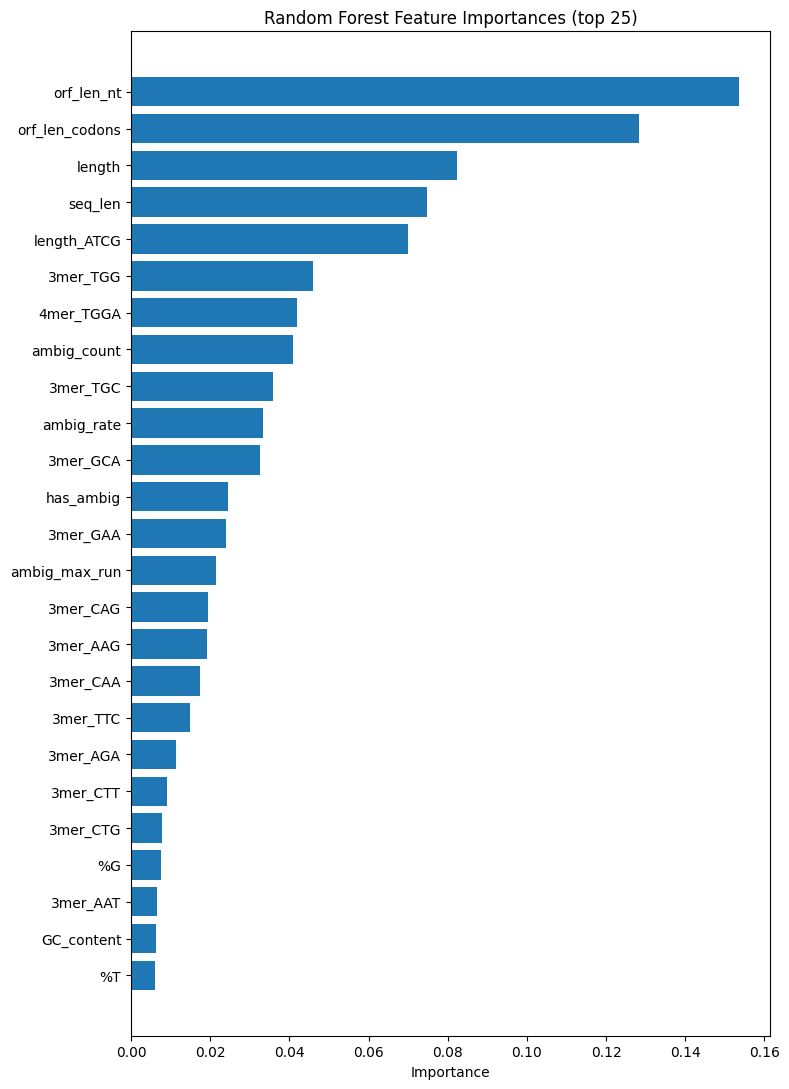

In [64]:
# === Feature importances ===
import numpy as np
imp = rf_full.feature_importances_
idx = np.argsort(imp)[::-1][:25]
plt.figure(figsize=(8, 0.32*len(idx)+3))
plt.barh(range(len(idx)), imp[idx][::-1])
plt.yticks(range(len(idx)), [list(X_all.columns)[i] for i in idx][::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (top 25)")
plt.tight_layout()
plt.show()

In [65]:
# --- Sanity on test probabilities ---
print("Probability Stats:", float(test_prob.min()), float(test_prob.max()), float(np.median(test_prob)))

used_threshold = float(best_thr)
test_pred = (test_prob >= used_threshold).astype(np.int8)

print(out.dtypes)
print(out.head())

Probability Stats: 0.0 1.0 0.5275000000000001
name               object
pred                int64
prob              float64
used_threshold    float64
dtype: object
             name  pred      prob  used_threshold
0  TCONS_00059596     1  0.985000           0.313
1  TCONS_00059678     1  0.995000           0.313
2  TCONS_00059721     1  0.999994           0.313
3  TCONS_00059758     1  0.992500           0.313
4  TCONS_00060154     1  0.980000           0.313


In [66]:
print("Probability Stats:", test_prob.min(), test_prob.max(), np.median(test_prob))
print("Unique Predictionss:", np.unique(test_pred, return_counts=True))

Probability Stats: 0.0 1.0 0.5275000000000001
Unique Predictionss: (array([0, 1], dtype=int8), array([2199, 2217]))


In [67]:
import joblib

# Save the trained model to a file
joblib.dump(rf_full, "random_forest_model.pkl")

['random_forest_model.pkl']

In [68]:
from google.colab import files

# Download the saved model
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>